# **Logistic Regression Part 2**

## Assumptions

In this lesson, we will cover the different assumptions that go into logistic regression, model hyperparameters, how to evaluate a classifier, ROC curves, and what to do when there’s a class imbalance in the classification problem we’re working with.

For this lesson, we will be using the Wisconsin Breast Cancer Data Set (Diagnostic) to predict whether a tumor is benign (`0`) or malignant (`1`) based on characteristics of the cells, such as radius, texture, smoothness, etc. Like a lot of real-world data sets, the distribution of outcomes is uneven (benign diagnoses are more common than malignant) and there is a bias in terms of the importance of the outcomes (classifying all malignant cases correctly is of the utmost importance).

We’re going to begin with the primary assumptions about the data that need to be checked before implementing a logistic regression model.

**1. The target variable is binary**

One of the most basic assumptions of logistic regression is that the outcome variable needs to be binary, which means there are two possible outcomes. Multinomial logistic regression is an exception to this assumption and is beyond the scope of this lesson.

**2. Independent observations**

While often overlooked, checking for independent observations in a data set is important for logistic regression. This can be violated if, in this case, patients are biopsied multiple times (repeated sampling of the same individual).

**3. Large enough sample size**

Since logistic regression is fit using maximum likelihood estimation instead of least squares minimization, there must be a large enough sample to get convergence. When a model fails to converge, this causes the estimates to be extremely inaccurate. Now, what does a “large enough” sample mean? Often a rule of thumb is that there should be at least 10 samples per feature for the smallest class in the outcome variable.

For example, if there were 100 samples and the outcome variable diagnosis had 60 benign tumors and 40 malignant tumors, then the max number of features allowed would be 4. To get 4 we took the smallest of the classes in the outcome variable, 40, and divided it by 10.

**4. No influential outliers**

Logistic regression is sensitive to outliers, so we must remove any extremely influential outliers for model building. Outliers are a broad topic with many different definitions – z-scores, scaler of the interquartile range, Cook’s distance/influence/leverage, etc – so there are many ways to identify them. But here, we will use visual tools to rule out obvious outliers. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, \
    roc_curve, roc_auc_score
from scipy.stats import zscore

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

response = requests.get(url)
with open('wdbc.data', 'wb') as f:
    f.write(response.content)
    
cols = ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
        'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean',
        'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se',
        'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se',
        'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
        'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst',
        'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']

df = pd.read_csv('wdbc.data', names=cols)

# encode malignant as 1, benign as 0
df['diagnosis'] = df['diagnosis'].replace({'M':1,'B':0})
# identify the predictor variables
predictor_vars = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
                  'smoothness_mean', 'compactness_mean', 'concavity_mean',
                  'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean']
model_vars = ['id', 'diagnosis'] + predictor_vars

# create a new dataframe with just the predictors, target and id
df = df[model_vars]
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [3]:
# print the distinct diagnosis values and frequencies
df.diagnosis.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [4]:
# check if there are no repeated patients
df.id.nunique() == len(df)

True

In [5]:
# check the maximum number of features
max_features = df.diagnosis.value_counts().min() / 10
int(max_features)

21

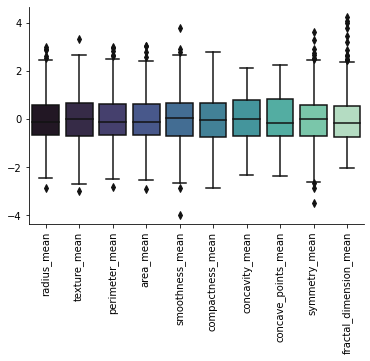

In [6]:
# check which features have extreme outliers
sns.boxplot(data=np.log(df[predictor_vars]+.01).apply(zscore), palette='mako')
plt.xticks(rotation=90)
sns.despine()

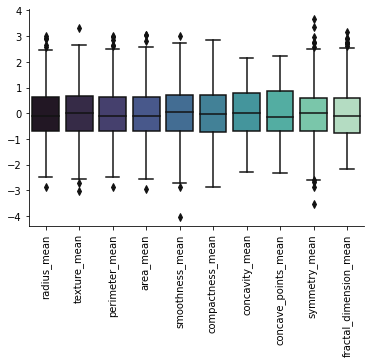

In [7]:
# remove any records above the 99th percentile for fractal_dimension_mean
q_hi = df.fractal_dimension_mean.quantile(0.99)
df_filtered = df[(df.fractal_dimension_mean < q_hi)]

sns.boxplot(data=np.log(df_filtered[predictor_vars]+.01).apply(zscore), palette='mako')
plt.xticks(rotation=90)
sns.despine()

**1. Features linearly related to log odds**

Similar to linear regression, the underlying assumption of logistic regression is that the features are linearly related to the logit of the outcome. To test this visually, we can use Seaborn’s regplot, with the parameter `logistic= True` and the x value as our feature of interest. If this condition is met, the fit model will resemble a sigmoidal curve (as is the case when `x=radius_mean`).

**2. Multicollinearity**

Like in linear regression, one of the assumptions is that there is no multicollinearity in the data. Meaning the features should not be highly correlated. Multicollinearity can cause the coefficients and p-values to be inaccurate. With a correlation plot, we can see which features are highly correlated and then we can drop one of the features.

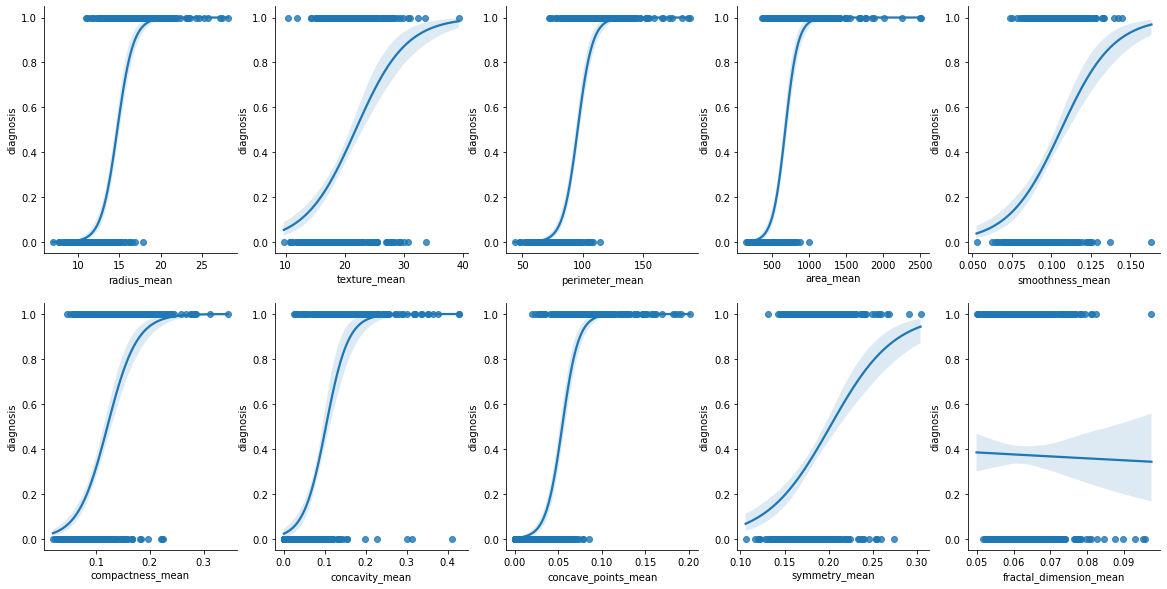

In [8]:
# compare the curves
fig, ax = plt.subplots(2, 5, figsize=(20,10))
for i, var in enumerate(predictor_vars):
    sns.regplot(x=var, y='diagnosis', data=df, logistic=True, ax=ax[i//5][i%5])

sns.despine()

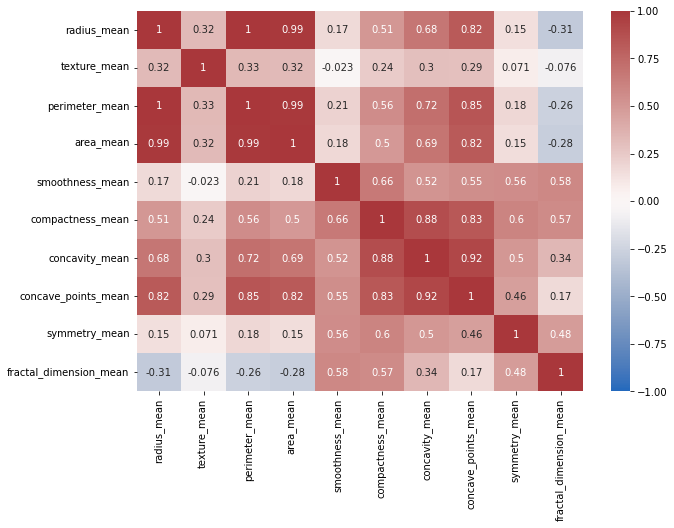

In [9]:
# identify the highly-correlated features
plt.figure(figsize=(10,7))
sns.heatmap(df[predictor_vars].corr(), annot=True, cmap="vlag", vmin=-1, vmax=1);

- area_mean is highly corelated with radius_mean (0.99), perimeter_mean (0.99) and concave_points_mean (0.82)
- concave_points_mean is highly correlated with radius_mean (0.82), perimeter_mean (0.82), compactness_mean (0.83) and concavity_mean (0.92)
- concavity_mean is highly correlated with compactness_mean (0.88)

## `scikit-learn` implementation

**Model training and hyperparameters**

Now that we have checked the assumptions of Logistic Regression, we can train and predict a model using `scikit-learn`. We will first set the hyperparameters of our model. Hyperparameters are set before the model implementation step and tuned later to improve model performance. Conversely, parameters are the result of model implementation, such as the intercept and coefficients.

**Evaluation metrics**

Despite the name, logistic regression is being used as a classifier here, so any evaluation metrics for classification tasks will apply. The simplest metric is accuracy – how many correct predictions did we make out of the total? However, when classes are imbalanced, this can be a misleading metric for model performance. Similarly, if we care more about accurately predicting a certain class, other metrics may be more appropriate to use, such as precision, recall, or F1-score may be better to evaluate performance. All of these metrics are available in `scikit-learn`.

```
Accuracy = (TP + TN)/Total
Precision = TP/(TP + FP)
Recall = TP/(TP + FN)
F1 score = 2*((Precision*Recall)/(Precision+Recall))
```

**Which metrics matter most?**

For our breast cancer dataset, predicting ALL malignant cases as malignant is of the utmost importance – and even if there are some false positives (benign cases that are marked as malignant), these likely will be discovered by follow-up tests. Whereas missing a malignant case (classifying it as benign) could have deadly consequences. Thus, we want to minimize false negatives. This in turn will maximize the recall ratio (also known as the sensitivity or true positive rate).

In [10]:
predictor_vars = ['radius_mean', 'texture_mean', 'compactness_mean', 'symmetry_mean']
target_var = 'diagnosis'

X_train, X_test, y_train, y_test = train_test_split(df[predictor_vars], df[target_var], random_state=0, test_size=0.3)

# fit a logistic regression model
log_reg = LogisticRegression(penalty='none', fit_intercept=True)
log_reg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [11]:
log_reg.fit(X_train, y_train)
intercept = log_reg.intercept_
coefs = log_reg.coef_

print(intercept)
print(coefs)

[-30.15566409]
[[ 1.07991529  0.28744917 30.96010078 29.9725165 ]]


In [12]:
# evaluate model performance on the test set
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Test set accuracy:\t{accuracy}')
print(f'Test set precision:\t{precision}')
print(f'Test set recall:\t{recall}')
print(f'Test set f1-score:\t{f1}')


Test set accuracy:	0.9064327485380117
Test set precision:	0.8507462686567164
Test set recall:	0.9047619047619048
Test set f1-score:	0.8769230769230769


In [13]:
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_pred), 
    index=['actual no', 'actual yes'], 
    columns=['predicted no', 'predicted yes']
)

test_conf_matrix

,predicted no,predicted yes
actual no,98,10
actual yes,6,57


## Prediction thresholds

Logistic regression not only predicts the class of a sample, but also the probability of a sample belonging to each class. It provides us with a measure of certainty associated with each prediction. In the default implementation in scikit-learn, a probability greater than 50% means that the predicted outcome will belong to the positive class. This is referred to as a prediction threshold. If two samples have predicted probabilities of 51% and 99%, both will be considered positive with the default threshold. However, if the threshold is increased to 60%, a predicted probability of 51% will be assigned the negative class.

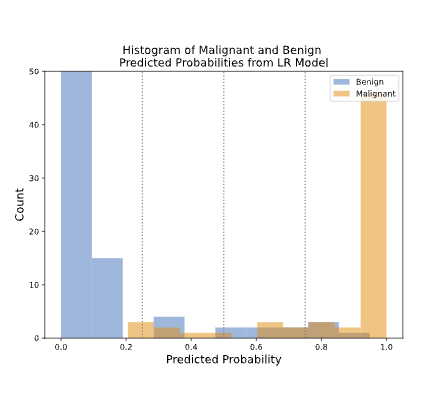

Consider the histogram of the predicted probabilities for the logistic regression classifier shown above. The benign (or negative class) is depicted in blue, and the malignant (or positive class) in orange for the breast cancer data set. The benign cases are heavily clustered around zero, which is good as they will be correctly classified as benign, whereas malignant cases are heavily clustered around one. The vertical lines depict hypothetical threshold values at 25%, 50%, and 75%. For the highest threshold, almost all the samples above 75% belong to the malignant class, but there will be some benign cases that are misdiagnosed as malignant (false positives). In addition, there are a number of malignant cases that are missed (false negatives). If instead the lowest threshold value is used, almost all the malignant cases are identified, but there are more false positives.

Therefore, the value of the threshold is an additional lever that can be used to tune a model’s predictions. A higher value is generally associated with fewer false positives and more false negatives. Whereas a lower value is associated with fewer false negatives and more false positives.

In [14]:
pred_probs = log_reg.predict_proba(X_test)[:, 1]
preds = (pred_probs > 0.5)

# check if the result is the same as using `predict`
diff = np.array_equal(preds, y_pred)
diff

True

In [15]:
print("Confusion Matrix: Threshold 50%")
cm_50 = confusion_matrix(y_test, preds)
print(cm_50)
print('-----')

print("Confusion Matrix: Threshold 25%")
preds = (pred_probs > 0.25)
cm_25 = confusion_matrix(y_test, preds)
print(cm_25)
print('-----')

print("Confusion Matrix: Threshold 50%")
preds = (pred_probs > 0.75)
cm_75 = confusion_matrix(y_test, preds)
print(cm_75)
print('-----')

Confusion Matrix: Threshold 50%
[[98 10]
 [ 6 57]]
-----
Confusion Matrix: Threshold 25%
[[94 14]
 [ 2 61]]
-----
Confusion Matrix: Threshold 50%
[[104   4]
 [ 11  52]]
-----


In [16]:
# choose the correct threshold
# minimize the number of false negatives, i.e., we’d like to correctly catch as many malignant cases as possible
# no more than 2 malignancies are misidentified, i.e., no more than 2 false negatives are allowed

# array of thresholds
thresh = np.linspace(0,1,100)
false_negatives = []

for t in thresh:
    cm = confusion_matrix(y_test, (pred_probs > t))
    false_negatives.append(cm[1][0])
    
thresh_results = pd.DataFrame(data={'threshold':thresh, 'num_FN':false_negatives})
filtered_results = thresh_results[thresh_results.num_FN == 2]
filtered_results

,threshold,num_FN
22,0.222222,2
23,0.232323,2
24,0.242424,2
25,0.252525,2


## ROC Curve and AUC

We have examined how changing the threshold can affect the logistic regression predictions, without retraining or changing the coefficients of the model. In essence, there is a continuum of predictions available in a single model by the varying the threshold incrementally from zero to one. For each of these thresholds, the true and false-positive rates can be calculated and then plot. The resulting curve these points form is known as the Receiver Operating Characteristic (ROC) curve.

To plot the ROC curve, we use `scikit-learn`'s `roc_curve` function, where the input contains the arrays `y_true` and `y_score` and output the arrays false-positive rate, true-positive rate, and threshold values. The plot of the true-positive rate vs false-positive rate gives us the ROC Curve.

The area under the curve (AUC) is a single numeric value, from zero to one, that is often used as a metric in evaluating classification models. A value close to one is a near-perfect classifier, whereas a value of 0.5 (which corresponds to the identity line, i.e. the dummy classifier!) is equivalent to random guessing (the null model).

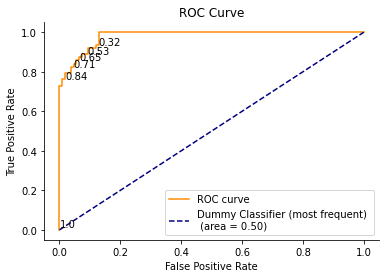

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve')

idx = list(range(len(thresholds)))[1::4]
for i in idx:
    plt.text(fpr[i], tpr[i], thresholds[i].round(2))

clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1] )
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, color='navy', linestyle='--', label='Dummy Classifier (most frequent) \n (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

sns.despine()

In [18]:
# print the ROC AUC score
roc_auc = roc_auc_score(y_test, pred_probs)
print(f'ROC AUC score: {roc_auc}')

ROC AUC score: 0.9810405643738976


## Class imbalance

Class imbalance is when your binary classes are not evenly split. Technically, anything different from a 50/50 distribution would be imbalanced and need appropriate care. However, the more imbalanced your data is, the more important it is to handle. In the case of rare events, sometimes the positive class can be less than 1% of the total.

The first issue that can arise is in randomly splitting your data – the smaller your dataset and more imbalanced the classes, the more likely there can be significant differences in classes for the training and test set. One way to mitigate this is to randomly split using stratification on the class labels. This ensures a nearly equal class distribution in your train and test sets.

In addition to using stratified sampling, class imbalance can be handled by undersampling the majority class or oversampling the minority class. For oversampling, repeated samples (with replacement) are taken from the minority class until the size is equal to that of the majority class. The downside is that the same data is used multiple times, giving a higher weight to these samples. On the other side, an undersampling used less of the majority class data to have equal size as the minority class. The downside here is that less data is used to build a model.

When training a model, the default setting is that every sample is weighted equally. However, in the case of class imbalance, this can result in poor predictive power in the smaller of the two classes. A way to counteract this in logistic regression is to use the parameter class_weight='balanced'. This applies a weight inversely proportional to the class frequently, therefore supplying higher weight to misclassified instances in the smaller class. While overall accuracy may not increase, this can increase the accuracy in the smaller class. Again in the breast cancer dataset, the most important classification is in the underrepresented malignant class.

In [19]:
# recall the results for the original model
print('Train positivity rate: ', sum(y_train)/y_train.shape[0])
print('Test positivity rate: ', sum(y_test)/y_test.shape[0])

recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('-----')
print('Recall and Accuracy scores')
print(recall, accuracy)

Train positivity rate:  0.3743718592964824
Test positivity rate:  0.3684210526315789
-----
Recall and Accuracy scores
0.9047619047619048 0.9064327485380117


In [20]:
# stratify the sample and repeat
X_train, X_test, y_train, y_test = train_test_split(df[predictor_vars], df[target_var], random_state=0, test_size=0.3, stratify=df[target_var])
print('Train positivity rate: ', sum(y_train)/y_train.shape[0])
print('Test positivity rate: ', sum(y_test)/y_test.shape[0])

log_reg = LogisticRegression(penalty='none', fit_intercept=True)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('-----')
print('Recall and Accuracy scores')
print(recall, accuracy)

Train positivity rate:  0.37185929648241206
Test positivity rate:  0.3742690058479532
-----
Recall and Accuracy scores
0.890625 0.9122807017543859


In [21]:
# balance the class weights and repeat
log_reg = LogisticRegression(penalty='none', fit_intercept=True, class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('Recall and Accuracy scores')
print(recall, accuracy)

Recall and Accuracy scores
0.921875 0.8947368421052632
